In [1]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import pickle as pkl
from itertools import islice
import datetime
import random
import itertools
import glob
import pickle as pkl
import time
import os
import fancyimpute, impyute
from fastdtw import fastdtw
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import euclidean, pdist
import scipy.signal

from keras.models import Sequential
from keras.layers import LSTM, Masking, Dense, RepeatVector, TimeDistributed

rootPath = '../IMDA/'


Populating the interactive namespace from numpy and matplotlib


/Users/phuw273g/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


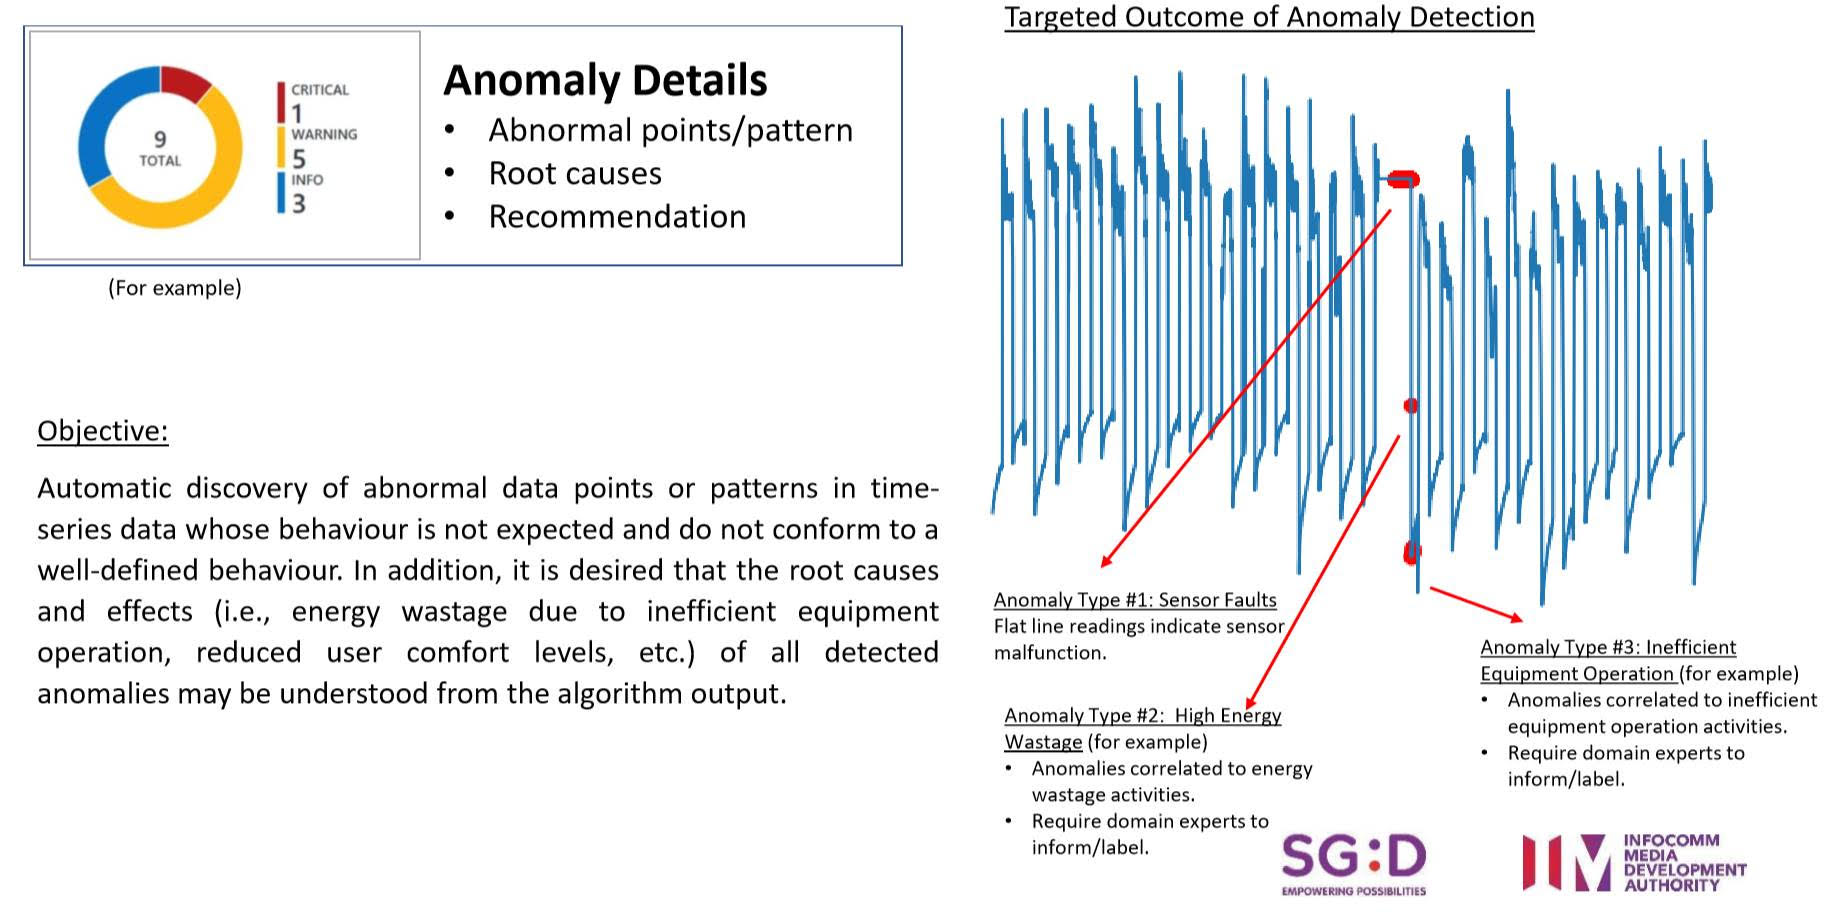

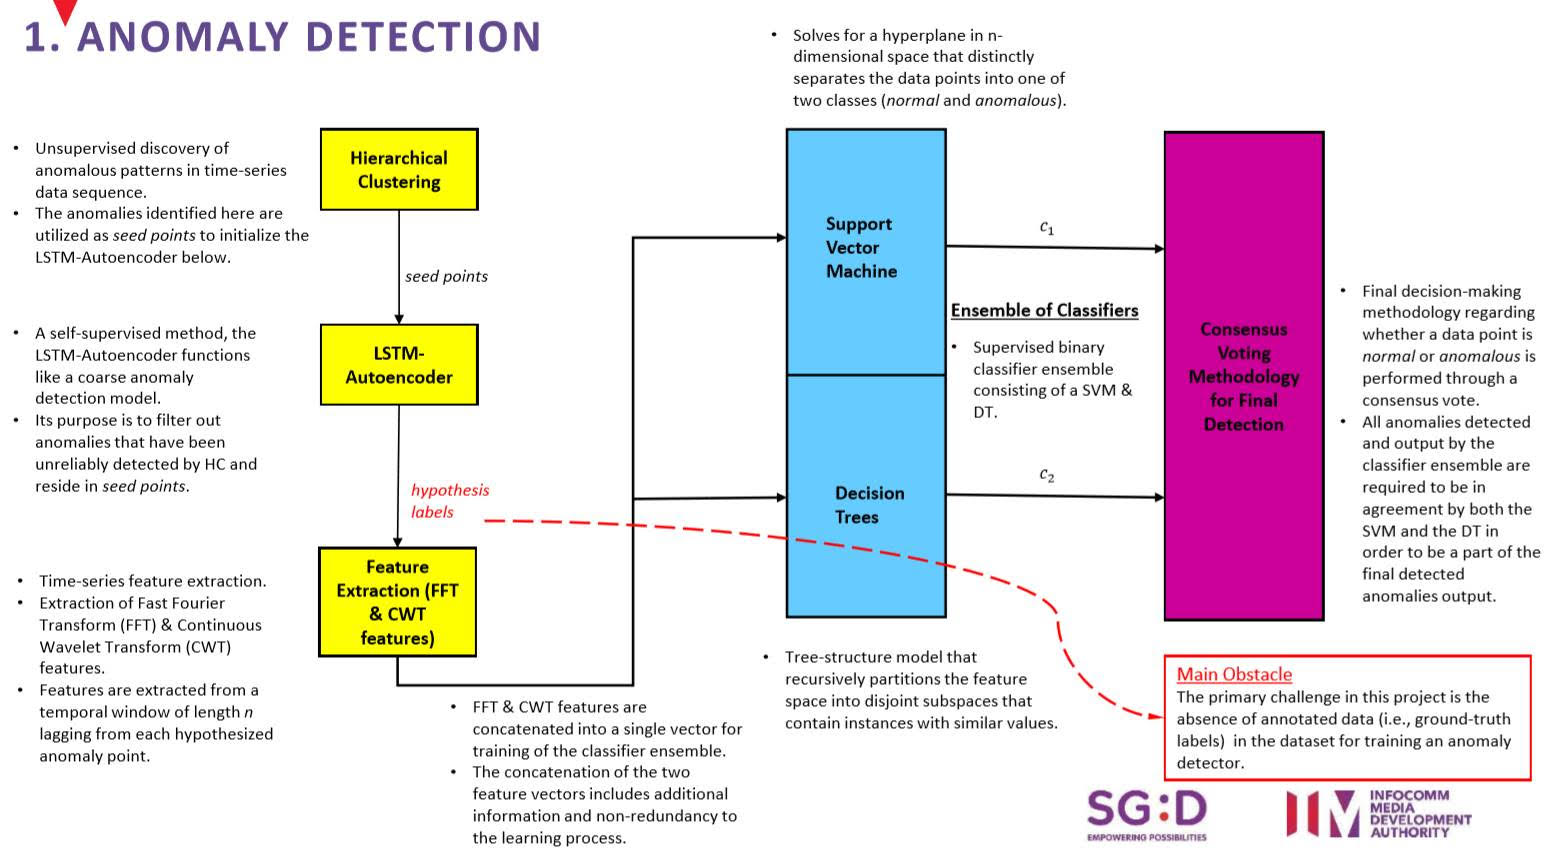


## Columns meaning:
 - CWRT: Condenser Water Return Temperature
 - HLI Entering CHW Temp: High Level Interface Entering (Return) Chilled Water Temperature

__*Anomaly Types*__ <br>
1. sensor fault
2. high energy wastage anomaly
3. inefficient equipment operation anomaly

In [2]:
maincols = ['CWRT_syth', 'HLI Entering CHW Temp']

In [3]:
data = pd.read_excel(rootPath+'Testcase_dataset-IBPEM.xlsx', index_col=None)
print(data.shape)
print(data.dtypes)
display(data.head())

(17719, 4)
Date                      object
Time                      object
CWRT_syth                float64
HLI Entering CHW Temp    float64
dtype: object


Date   Time  CWRT_syth  HLI Entering CHW Temp
0  2019-01-13  0000h  31.090000                    NaN
1  2019-01-13  0005h  31.106000                    NaN
2  2019-01-13  0010h  31.129999                   10.6
3  2019-01-13  0015h  31.146000                    NaN
4  2019-01-13  0020h  31.170000                    NaN

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data['DateTime'] = (data['Date'] + ' ' + data['Time'].apply(lambda x: x[:2]+':'+x[2:-1]+':00')).apply(dateparse)
data = data.set_index('DateTime')
print(data.shape)
print(data.dtypes)
print(min(data.index), max(data.index))
display(data.head())

display(data.describe())

(17719, 4)
Date                      object
Time                      object
CWRT_syth                float64
HLI Entering CHW Temp    float64
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


Date   Time  CWRT_syth  HLI Entering CHW Temp
DateTime                                                                
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN

CWRT_syth  HLI Entering CHW Temp
count  17615.000000            5868.000000
mean      34.761378              13.929772
std        3.042954               1.861147
min        0.000000               9.100000
25%       32.669998              13.000000
50%       35.330001              13.500000
75%       36.368999              14.800000
max       50.804002              23.700001

In [5]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data.index, data['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data.index, data['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data.index.to_frame()
tmp['wkday'] = data.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    
plt.show()

### find period

In [8]:
def getautocorrelation(pds_, corr_cutoff=50, pctpdsuse=0.7):
    pds = pds_.dropna().copy()
    nts = int(len(pds)*0.70)
    autocorr = [pds.shift(i).corr(pds) for i in range(nts)]
    autocorr_pds = pd.Series(autocorr, index=pds.index[:len(autocorr)])
    cutoff = np.percentile(autocorr, corr_cutoff)
    autocorr_pds_highscore = autocorr_pds[autocorr_pds>cutoff].to_frame()
    autocorr_pds_highscore['gap'] = pd.Series(
        autocorr_pds_highscore.index, index=autocorr_pds_highscore.index) - pd.Series(
        autocorr_pds_highscore.index, index=autocorr_pds_highscore.index).shift(1)
    gaps = autocorr_pds_highscore['gap'].value_counts().index[1:]
    tmp = autocorr_pds_highscore[autocorr_pds_highscore['gap'].isin(gaps)].copy()
    tmp['half_gap'] = tmp['gap']/2
    tmp['point'] = pd.Series(tmp.index, index=tmp.index) + tmp['half_gap']
    tmp['point_diff'] = tmp['point']-tmp['point'].shift(1)
    return tmp['point_diff'].median()
       

In [9]:
periods = {}

for col in maincols:
    tmp = data[col]
    #tmp = data[col].interpolate(method='polynomial', order=1) 
    periods[col] = getautocorrelation(tmp, corr_cutoff=50)
    
periods    

{'CWRT_syth': Timedelta('0 days 23:50:00'),
 'HLI Entering CHW Temp': Timedelta('0 days 23:45:00')}

## <font color='purple'>Anomaly Type 1: Single Feature - inconsistent time gap</font>
- <font color='grey'>look at the entire dataframe, fill missed timestamp, if any</font>
- <font color='grey'>flag wrong time gap</font>

In [10]:
def findcorrectgap(pds, pctthreshold):
    gapcnt = pds['gap'].value_counts(ascending=False)
    if gapcnt.iloc[0] / gapcnt.sum() > pctthreshold:
        correct_gap = gapcnt.index[0]    
    else:
        correct_gap = None
    return correct_gap


def flaginconsistenttimegap(pds, pctthreshold):
    # pds: pd series with index as datetime
    tmp = pds.dropna().sort_index(ascending=True).to_frame()
    timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
    tmp['gap'] = pd.Series(list(timediff), index = tmp.index)
    
    correct_gap = findcorrectgap(tmp, pctthreshold)
    if correct_gap is not None:
        tmp['wrong_gap'] = False
        firstind = tmp.index[0]
        tmp.loc[(tmp['gap'] != correct_gap)&(tmp.index != firstind), 'wrong_gap'] = True
        result = pd.concat([pds.to_frame(), tmp.loc[tmp['wrong_gap'], ['gap', 'wrong_gap']]], axis=1)
        result['prev_dt'] = result.index.to_series() - result['gap'] + correct_gap
        result['periods_missed'] = result['gap'].div(correct_gap)
        result['dt_missed'] = None
        result.loc[result['prev_dt'].notna(), 'dt_missed'] = result[result['prev_dt'].notna()].apply(
            lambda row: 
            list(pd.date_range(str(row['prev_dt']), periods=int(row['periods_missed']-1), freq=correct_gap)) 
            if int(row['periods_missed']-1) > 0 else [row['prev_dt']], 
            axis=1)
        all_missed_dt = result[~result['wrong_gap'].isna()]['dt_missed'].sum(axis=0)
        result['wrong_gap']=False  ###
        result.loc[result.index.isin(all_missed_dt), 'wrong_gap'] = True
        result.loc[result['wrong_gap'] != True, 'wrong_gap'] = False
        result.loc[result['periods_missed']%1==0, 'wrong_gap'] = False
    else:
        result = pds.copy()
        result['wrong_gap']=None
        
    return result   


In [11]:
# ------------- fill missed timestamp, if any ------------------
tmp = data['Date'].sort_index(ascending=True).to_frame()
timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
tmp['gap'] = pd.Series(list(timediff), index = tmp.index)

correct_df_gap = findcorrectgap(tmp, 0.7)
data = data.sort_index(ascending=True)

print(data.shape)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=correct_df_gap))
print(data.shape)

(17719, 4)
(17719, 4)


In [12]:
# ------------- flag wrong time gap ------------------
tmp = flaginconsistenttimegap(data['CWRT_syth'], 0.7)
tmp2 = flaginconsistenttimegap(data['HLI Entering CHW Temp'],  0.7)
data_2 = pd.concat(
    [data, 
     tmp[['wrong_gap']].rename(columns={'wrong_gap': 'LABEL_(CWRT_syth)_(wrong_gap)'}), 
     tmp2[['wrong_gap']].rename(columns={'wrong_gap': 'LABEL_(HLI Entering CHW Temp)_(wrong_gap)'})], 
    axis=1)

data_2.head()

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  
2019-01-13 00:00:00                                      False  
2019-01-13 00:05:00                                      False  
2019-01-13 00:10:00                                      False  
2019-01-13 00:15:00                                      False  
2019-01-13 00:20:00                                      False

In [13]:
# check
display(data_2['2019-01-21 07': '2019-01-21 08'])
display(data_2['2019-03-07 19': '2019-03-07 23'])

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-21 07:00:00  2019-01-21  0700h        NaN                    NaN   
2019-01-21 07:05:00  2019-01-21  0705h        NaN                    NaN   
2019-01-21 07:10:00  2019-01-21  0710h        NaN                    NaN   
2019-01-21 07:15:00  2019-01-21  0715h        NaN                    NaN   
2019-01-21 07:20:00  2019-01-21  0720h        NaN                    NaN   
2019-01-21 07:25:00  2019-01-21  0725h        NaN                    NaN   
2019-01-21 07:30:00  2019-01-21  0730h        NaN                    NaN   
2019-01-21 07:35:00  2019-01-21  0735h        NaN                    NaN   
2019-01-21 07:40:00  2019-01-21  0740h        NaN                    NaN   
2019-01-21 07:45:00  2019-01-21  0745h        NaN                    NaN   
2019-01-21 07:50:00  2019-01-21  0750h        NaN                    NaN   
2019-01-21 07:55:00  2019-01-21  0755h        NaN                    NaN   
2019-01-21 08:00:00  2019-01-21  0800h        NaN                    NaN   
2019-01-21 08:05:00  2019-01-21  0805h  32.709999                    NaN   
2019-01-21 08:10:00  2019-01-21  0810h  32.709999              15.800000   
2019-01-21 08:15:00  2019-01-21  0815h  32.709999                    NaN   
2019-01-21 08:20:00  2019-01-21  0820h  32.719999                    NaN   
2019-01-21 08:25:00  2019-01-21  0825h  32.759998              16.000000   
2019-01-21 08:30:00  2019-01-21  0830h        NaN                    NaN   
2019-01-21 08:35:00  2019-01-21  0835h  32.719999                    NaN   
2019-01-21 08:40:00  2019-01-21  0840h  32.759998              16.000000   
2019-01-21 08:45:00  2019-01-21  0845h  32.767999                    NaN   
2019-01-21 08:50:00  2019-01-21  0850h  32.799999                    NaN   
2019-01-21 08:55:00  2019-01-21  0855h  32.799999              16.200001   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-21 07:00:00                           True   
2019-01-21 07:05:00                           True   
2019-01-21 07:10:00                           True   
2019-01-21 07:15:00                           True   
2019-01-21 07:20:00                           True   
2019-01-21 07:25:00                           True   
2019-01-21 07:30:00                           True   
2019-01-21 07:35:00                           True   
2019-01-21 07:40:00                           True   
2019-01-21 07:45:00                           True   
2019-01-21 07:50:00                           True   
2019-01-21 07:55:00                           True   
2019-01-21 08:00:00                           True   
2019-01-21 08:05:00                          False   
2019-01-21 08:10:00                          False   
2019-01-21 08:15:00                          False   
2019-01-21 08:20:00                          False   
2019-01-21 08:25:00                          False   
2019-01-21 08:30:00                           True   
2019-01-21 08:35:00                          False   
2019-01-21 08:40:00                          False   
2019-01-21 08:45:00                          False   
2019-01-21 08:50:00                          False   
2019-01-21 08:55:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  
2019-01-21 07:00:00                                      False  
2019-01-21 07:05:00                                      False  
2019-01-21 07:10:00                                       True  
2019-01-21 07:15:00                                      False  
2019-01-21 07:20:00                                      False  
2019-01-21 07:25:00                                       True  
2019-01-21 07:30:00                                      False  
2019-01-21 07:35:00                                      False  
2019-01-21 07:40:00                                       True  
2019-01-21 07:45:00                                      False  
2019-01-21 07:50:00                                      Fal

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-03-07 19:00:00  2019-03-07  1900h  35.491999                    NaN   
2019-03-07 19:05:00  2019-03-07  1905h  35.542000                    NaN   
2019-03-07 19:10:00  2019-03-07  1910h  35.860000                    NaN   
2019-03-07 19:15:00  2019-03-07  1915h  35.834000              13.500000   
2019-03-07 19:20:00  2019-03-07  1920h  35.630000                    NaN   
2019-03-07 19:25:00  2019-03-07  1925h  35.390000              13.500000   
2019-03-07 19:30:00  2019-03-07  1930h  35.356001                    NaN   
2019-03-07 19:35:00  2019-03-07  1935h  35.598000                    NaN   
2019-03-07 19:40:00  2019-03-07  1940h  35.920000                    NaN   
2019-03-07 19:45:00  2019-03-07  1945h  35.912000              13.500000   
2019-03-07 19:50:00  2019-03-07  1950h  35.622000                    NaN   
2019-03-07 19:55:00  2019-03-07  1955h  35.356001              13.400001   
2019-03-07 20:00:00  2019-03-07  2000h  35.439999                    NaN   
2019-03-07 20:05:00  2019-03-07  2005h  35.606000                    NaN   
2019-03-07 20:10:00  2019-03-07  2010h  35.782000                    NaN   
2019-03-07 20:15:00  2019-03-07  2015h  35.662000              13.400001   
2019-03-07 20:20:00  2019-03-07  2020h  35.338000                    NaN   
2019-03-07 20:25:00  2019-03-07  2025h  35.440000              13.300000   
2019-03-07 20:30:00  2019-03-07  2030h  35.708001                    NaN   
2019-03-07 20:35:00  2019-03-07  2035h  35.680001                    NaN   
2019-03-07 20:40:00  2019-03-07  2040h  35.364001                    NaN   
2019-03-07 20:45:00  2019-03-07  2045h  35.416000              13.400001   
2019-03-07 20:50:00  2019-03-07  2050h  35.721999                    NaN   
2019-03-07 20:55:00  2019-03-07  2055h  35.638000                    NaN   
2019-03-07 21:00:00  2019-03-07  2100h  35.408001              13.400001   
2019-03-07 21:05:00  2019-03-07  2105h  35.516000                    NaN   
2019-03-07 21:10:00  2019-03-07  2110h  35.884001                    NaN   
2019-03-07 21:15:00  2019-03-07  2115h  35.800000              13.400001   
2019-03-07 21:20:00  2019-03-07  2120h  35.160000                    NaN   
2019-03-07 21:25:00  2019-03-07  2125h  34.809999                    NaN   
2019-03-07 21:30:00  2019-03-07  2130h  34.767999              12.700000   
2019-03-07 21:35:00  2019-03-07  2135h  35.000001                    NaN   
2019-03-07 21:40:00  2019-03-07  2140h  35.091999                    NaN   
2019-03-07 21:45:00  2019-03-07  2145h  35.099998              12.600000   
2019-03-07 21:50:00  2019-03-07  2150h  34.914000                    NaN   
2019-03-07 21:55:00  2019-03-07  2155h  34.575999                    NaN   
2019-03-07 22:00:00  2019-03-07  2200h  34.517999              12.300000   
2019-03-07 22:05:00  2019-03-07  2205h  34.483999                    NaN   
2019-03-07 22:10:00  2019-03-07  2210h  32.284001              11.700000   
2019-03-07 22:15:00  2019-03-07  2215h  32.176000                    NaN   
2019-03-07 22:20:00  2019-03-07  2220h  32.160000                    NaN   
2019-03-07 22:25:00  2019-03-07  2225h  32.192001                    NaN   
2019-03-07 22:30:00  2019-03-07  2230h  32.200001              11.700000   
2019-03-07 22:35:00  2019-03-07  2235h  32.232001                    NaN   
2019-03-07 22:40:00  2019-03-07  2240h  32.240002                    NaN   
2019-03-07 22:45:00  2019-03-07  2245h  32.280001              12.000000   
2019-03-07 22:50:00  2019-03-07  2250h  32.290001                    NaN   
2019-03-07 22:55:00  2019-03-07  2255h  32.322002              12.000000   
2019-03-07 23:00:00  2019-03-07  2300h  32.362000                    NaN   
2019-03-07 23:05:00  2019-03-07  2305h  32.369999                    NaN   
2019-03-07 23:10:00  2019-03-07  2310h  32.369999                    NaN   
2019-03-07 23:15:00  2019-03-07  2315h  32.402000              12.100000   

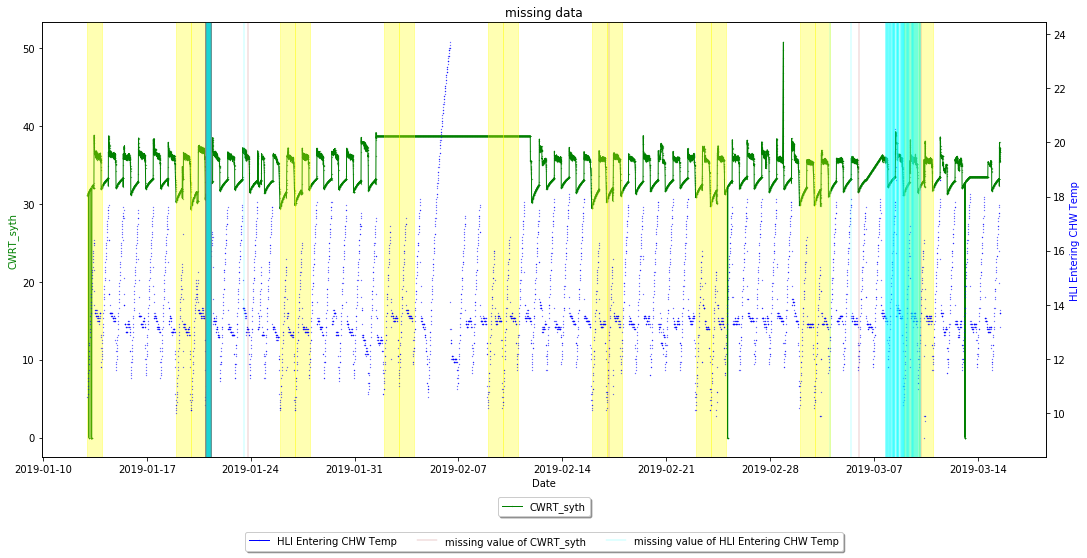

In [14]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2.index, data_2['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2.index, data_2['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    
# plot outliers
for col, clr in zip(maincols, ['brown', 'cyan']):
    ts_missing = list(data_2[data_2['LABEL_('+col+')_(wrong_gap)']].index)
    i=0
    for dt in ts_missing:
        if i == len(ts_missing)-1:
            plt.axvline(dt, alpha=0.6, color=clr, linewidth=0.4, label='missing value of '+col)
        else:
            plt.axvline(dt, alpha=0.6, linewidth=0.4, color=clr)
        i += 1

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.title('missing data')
plt.show()

## Add More Features

In [15]:
#data_2['year'] = data.index.year
#data_2['month'] = data.index.month
data_2['day'] = data_2.index.day
data_2['weekday'] = data_2.index.weekday+1
data_2['hourminute'] = data_2.index.hour*60+data_2.index.minute
data_2.head()

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  day  weekday  \
2019-01-13 00:00:00                                      False   13        7   
2019-01-13 00:05:00                                      False   13        7   
2019-01-13 00:10:00                                      False   13        7   
2019-01-13 00:15:00                                      False   13        7   
2019-01-13 00:20:00                                      False   13        7   

                     hourminute  
2019-01-13 00:00:00           0  
2019-01-13 00:05:00           5  
2019-01-13 00:10:00          10  
2019-01-13 00:15:00          15  
2019-01-13 00:20:00          20

## <font color='purple'>Anomaly Type 2: Single Variate Outliers</font>

In [16]:
st_factor = 2.5  # adjustable

for col in maincols:
    labelcol = 'LABEL_('+col+')_(extreme_value)'
    data_2[labelcol] = False
    st = data_2[col].std()
    ave = data_2[col].mean()
    data_2.loc[(data_2[col]<ave-st_factor*st) | (data_2[col]>ave+st_factor*st), labelcol] = True
    print(col, 'single variante exteme value outlier:', len(data_2[data_2[labelcol]]), 'rows')

CWRT_syth single variante exteme value outlier: 51 rows
HLI Entering CHW Temp single variante exteme value outlier: 87 rows


In [17]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2.index, data_2['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2.index, data_2['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    
# plot outliers
sub1 = data_2[data_2['LABEL_(CWRT_syth)_(extreme_value)']].copy()
ax1.plot_date(sub1.index, sub1['CWRT_syth'], 
              c='brown', markersize=7, marker='.', linewidth=1, linestyle='', label='(CWRT_syth) Outlier')
sub2 = data_2[data_2['LABEL_(HLI Entering CHW Temp)_(extreme_value)']].copy()
ax2.plot_date(sub2.index, sub2['HLI Entering CHW Temp'], 
              c='cyan', markersize=7,  marker='.', linewidth=1, linestyle='', label='(HLI Entering CHW Temp) Outlier')
   
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()

## <font color='purple'>Anomaly Type 3: Single Variate Profile Inconsistency</font>
1. <font color='grey'>make sure no timestamp is missed</font>
2. <font color='grey'>replace single variate exteme values and missing values with mean of the similar time - data_2_modified</font>
3. <font color='grey'>cluster based on data_2_modified (data from 2), minority clusters is considered as outliers, obtain majority cluster, and use it to train and onderfitted model - further outlier detection.</font>

In [18]:
def replaceoutlier(df_, col, how='mean', timecols=['weekday', 'hourminute']):
    df = df_.copy()
    oulierlabel_cols = ['LABEL_('+col+')_(extreme_value)', 'LABEL_('+col+')_(wrong_gap)']    
    condition_1 = (df[oulierlabel_cols]==False).sum(axis=1)==len(oulierlabel_cols)
    grp = df[condition_1].groupby(timecols)[col] #######
    if how=='mean':
        meanvals = grp.mean().to_frame()
    else:
        meanvals = grp.median().to_frame()
    meanvals.reset_index(inplace=True)
    meanvals = meanvals.rename(columns={col: 'replace_val'})
    df = df.merge(meanvals, on=timecols, how='left', left_index=True, right_index=False).set_index(df_.index)
    condition_2 = (df[oulierlabel_cols]==True).sum(axis=1)>0
    df.loc[condition_2, col] = df.loc[condition_2, 'replace_val'] 

    return df.drop('replace_val', axis=1)

def fillwithmean(df_, grocol='weekday'):
    df = df_.copy()
    tmp = df.describe().T
    colstofill = list(tmp[tmp['count']<len(df)].index)
    grpmean = df.groupby(grocol)[colstofill].mean()
    replacevalcols = ['replace_'+c for c in list(grpmean)]
    grpmean.columns = replacevalcols
    grpmean.reset_index(inplace=True)
    df = df.merge(grpmean, how='left', on=grocol).set_index(df.index)
    for col in colstofill:
        df.loc[df[col].isna(), col] = df.loc[df[col].isna(), 'replace_'+col]
    return df.drop(replacevalcols, axis=1)

def stdnormalize(pds):
    m = pds.mean()
    st = pds.std()
    absmx = abs(pds).max()
    if st > 0:
        result = (pds-m).div(st)
    else:
        result = pds-m
    return result.replace(-np.inf, -absmx*100).replace(np.inf, absmx*100).replace(np.nan, m)

#### Apply directly to uncleaned data

In [25]:
dfs = []
for col in maincols:
    tmp = data_2.pivot(index='Date', columns='hourminute', values=col)
    tmp.columns = [col+'_'+str(c) for c in list(tmp)]
    dfs += [tmp]
dailypattern_uncleaned = pd.concat(dfs, axis=1)

display(dailypattern_uncleaned.head())

dailypattern_uncleaned_smry = dailypattern_uncleaned.describe().T
display(dailypattern_uncleaned_smry.head())

CWRT_syth_0  CWRT_syth_5  CWRT_syth_10  CWRT_syth_15  \
Date                                                               
2019-01-13    31.090000    31.106000     31.129999     31.146000   
2019-01-14    32.330002    32.346001     32.369999     32.385999   
2019-01-15    32.290001    32.290001     32.358000     32.459999   
2019-01-16    31.660000    31.690001     31.690001     31.706000   
2019-01-17    32.338001    32.369999     32.369999     32.369999   

            CWRT_syth_20  CWRT_syth_25  CWRT_syth_30  CWRT_syth_35  \
Date                                                                 
2019-01-13     31.170000         31.19     31.219999     31.219999   
2019-01-14     32.410000         32.41     32.410000     32.430000   
2019-01-15     32.475999         32.50     32.500000     32.516000   
2019-01-16     31.730000         31.73     31.746000     31.770000   
2019-01-17     32.377999         32.41     32.410000     32.410000   

            CWRT_syth_40  CWRT_syth_45  CWRT_syth_50  CWRT_syth_55  \
Date                                                                 
2019-01-13     31.236000     31.276000     31.299999     31.299999   
2019-01-14     32.459999     32.475999     32.500000     32.500000   
2019-01-15     32.540001     32.540001     32.560001     32.570000   
2019-01-16     31.790000     31.820000     31.820000     31.820000   
2019-01-17     32.420000     32.459999     32.459999     32.459999   

            CWRT_syth_60  CWRT_syth_65  CWRT_syth_70  CWRT_syth_75  \
Date                                                                 
2019-01-13     31.316000     31.340000     31.360000     31.389999   
2019-01-14     32.500000     32.516000     32.540001     32.540001   
2019-01-15     32.560001     32.590000     32.590000     32.590000   
2019-01-16     31.836000     31.860001     31.876000     31.900000   
2019-01-17     32.467999     32.500000     32.500000     32.500000   

            CWRT_syth_80  CWRT_syth_85  CWRT_syth_90  CWRT_syth_95  \
Date                                                                 
2019-01-13     31.389999     31.406000     31.430000     31.446000   
2019-01-14     32.560001     32.590000     32.590000     32.590000   
2019-01-15     32.606001     32.630001     32.630001     32.646000   
2019-01-16     31.900000     31.916000     31.940001     31.940001   
2019-01-17     32.508000     32.540001     32.540001     32.550001   

            CWRT_syth_100  CWRT_syth_105  CWRT_syth_110  CWRT_syth_115  \
Date                                                                     
2019-01-13      31.469999      31.469999      31.469999      31.490000   
2019-01-14      32.590000      32.606001      32.630001      32.630001   
2019-01-15      32.669998      32.669998      32.669998      32.685999   
2019-01-16      31.940001      31.960000      31.990000      31.990000   
2019-01-17      32.590000      32.590000      32.590000      32.590000   

            CWRT_syth_120  CWRT_syth_125  CWRT_syth_130  CWRT_syth_135  \
Date                                                                     
2019-01-13       0.000000       0.000000       0.000000       0.000000   
2019-01-14      32.646000      32.669998      32.669998      32.669998   
2019-01-15      32.709999      32.709999      32.709999      32.709999   
2019-01-16      32.005999      32.029999      32.029999      32.029999   
2019-01-17      32.598000      32.630001      32.630001      32.630001   

            CWRT_syth_140  CWRT_syth_145  CWRT_syth_150  CWRT_syth_155  \
Date                                                                     
2019-01-13       0.000000       0.000000      31.616000      31.639999   
2019-01-14      32.669998      32.685999      32.709999      32.709999   
2019-01-15      32.729999      32.759998      32.759998      32.759998   
2019-01-16      32.045999      32.070000      32.086000      32.110001   
2019-01-17      32.638000      32.669998      32.669998      32.669998   

            CW

count       mean       std        min        25%        50%  \
CWRT_syth_0    61.0  32.880721  2.770460  29.670000  31.660000  32.110001   
CWRT_syth_5    61.0  32.896689  2.761789  29.670000  31.690001  32.160000   
CWRT_syth_10   60.0  32.926100  2.775328  29.719999  31.661500  32.180000   
CWRT_syth_15   61.0  32.927934  2.746700  29.752000  31.706000  32.160000   
CWRT_syth_20   61.0  32.941180  2.739743  29.760000  31.730000  32.200001   

                    75%    max  
CWRT_syth_0   32.410000  38.75  
CWRT_syth_5   32.410000  38.75  
CWRT_syth_10  32.441500  38.75  
CWRT_syth_15  32.459999  38.75  
CWRT_syth_20  32.475999  38.75

In [26]:
# remove the columns dailypattern where count is too few
dropcols = list(dailypattern_uncleaned_smry[dailypattern_uncleaned_smry['count']<len(dailypattern_uncleaned)*0.8].index)
print('drop columns:', len(dropcols))

print(dailypattern_uncleaned.shape)
dailypattern_uncleaned = dailypattern_uncleaned.drop(dropcols, axis=1)
print(dailypattern_uncleaned.shape)
display(dailypattern_uncleaned.head())

dailypattern_uncleaned.index = list(dailypattern_uncleaned.index.to_series().apply(
    lambda x: pd.datetime.strptime(x, '%Y-%m-%d')))
dailypattern_uncleaned['weekday'] = dailypattern_uncleaned.index.weekday+1

print(dailypattern_uncleaned.shape)
dailypattern_uncleaned = fillwithmean(dailypattern_uncleaned, grocol='weekday')
print(dailypattern_uncleaned.shape)

drop columns: 192
(62, 576)
(62, 384)


CWRT_syth_0  CWRT_syth_5  CWRT_syth_10  CWRT_syth_15  \
Date                                                               
2019-01-13    31.090000    31.106000     31.129999     31.146000   
2019-01-14    32.330002    32.346001     32.369999     32.385999   
2019-01-15    32.290001    32.290001     32.358000     32.459999   
2019-01-16    31.660000    31.690001     31.690001     31.706000   
2019-01-17    32.338001    32.369999     32.369999     32.369999   

            CWRT_syth_20  CWRT_syth_25  CWRT_syth_30  CWRT_syth_35  \
Date                                                                 
2019-01-13     31.170000         31.19     31.219999     31.219999   
2019-01-14     32.410000         32.41     32.410000     32.430000   
2019-01-15     32.475999         32.50     32.500000     32.516000   
2019-01-16     31.730000         31.73     31.746000     31.770000   
2019-01-17     32.377999         32.41     32.410000     32.410000   

            CWRT_syth_40  CWRT_syth_45  CWRT_syth_50  CWRT_syth_55  \
Date                                                                 
2019-01-13     31.236000     31.276000     31.299999     31.299999   
2019-01-14     32.459999     32.475999     32.500000     32.500000   
2019-01-15     32.540001     32.540001     32.560001     32.570000   
2019-01-16     31.790000     31.820000     31.820000     31.820000   
2019-01-17     32.420000     32.459999     32.459999     32.459999   

            CWRT_syth_60  CWRT_syth_65  CWRT_syth_70  CWRT_syth_75  \
Date                                                                 
2019-01-13     31.316000     31.340000     31.360000     31.389999   
2019-01-14     32.500000     32.516000     32.540001     32.540001   
2019-01-15     32.560001     32.590000     32.590000     32.590000   
2019-01-16     31.836000     31.860001     31.876000     31.900000   
2019-01-17     32.467999     32.500000     32.500000     32.500000   

            CWRT_syth_80  CWRT_syth_85  CWRT_syth_90  CWRT_syth_95  \
Date                                                                 
2019-01-13     31.389999     31.406000     31.430000     31.446000   
2019-01-14     32.560001     32.590000     32.590000     32.590000   
2019-01-15     32.606001     32.630001     32.630001     32.646000   
2019-01-16     31.900000     31.916000     31.940001     31.940001   
2019-01-17     32.508000     32.540001     32.540001     32.550001   

            CWRT_syth_100  CWRT_syth_105  CWRT_syth_110  CWRT_syth_115  \
Date                                                                     
2019-01-13      31.469999      31.469999      31.469999      31.490000   
2019-01-14      32.590000      32.606001      32.630001      32.630001   
2019-01-15      32.669998      32.669998      32.669998      32.685999   
2019-01-16      31.940001      31.960000      31.990000      31.990000   
2019-01-17      32.590000      32.590000      32.590000      32.590000   

            CWRT_syth_120  CWRT_syth_125  CWRT_syth_130  CWRT_syth_135  \
Date                                                                     
2019-01-13       0.000000       0.000000       0.000000       0.000000   
2019-01-14      32.646000      32.669998      32.669998      32.669998   
2019-01-15      32.709999      32.709999      32.709999      32.709999   
2019-01-16      32.005999      32.029999      32.029999      32.029999   
2019-01-17      32.598000      32.630001      32.630001      32.630001   

            CWRT_syth_140  CWRT_syth_145  CWRT_syth_150  CWRT_syth_155  \
Date                                                                     
2019-01-13       0.000000       0.000000      31.616000      31.639999   
2019-01-14      32.669998      32.685999      32.709999      32.709999   
2019-01-15      32.729999      32.759998      32.759998      32.759998   
2019-01-16      32.045999      32.070000      32.086000      32.110001   
2019-01-17      32.638000      32.669998      32.669998      32.669998   

            CW

(62, 385)
(62, 385)


In [27]:
# ------------- 'CWRT_syth' -------------------
col = 'CWRT_syth'
time0 = time.time()
tmp = dailypattern_uncleaned[[c for c in list(dailypattern_uncleaned) if col in c]].copy()
for x in list(tmp):
    tmp[x] = stdnormalize(tmp[x])

def dmf(u, v):
    result, _ = fastdtw(u, v, dist=euclidean)
    return result

linked = linkage(tmp.values, method='single', metric=dmf)  #  metric=dmf  or  'euclidean'
dailypattern_uncleaned[col+'_cluster'] = fcluster(linked, 6, 'maxclust')
display(dailypattern_uncleaned[col+'_cluster'].value_counts(ascending=True))
print('total time used', time.time()-time0)

2     1
4     1
5     1
6     1
1     9
3    49
Name: CWRT_syth_cluster, dtype: int64

total time used 186.67355680465698


In [28]:
minor_clusters = list(dailypattern_uncleaned[col+'_cluster'].value_counts(ascending=True).index[:5])  # adjustable
abnormaldays = [str(x) for x in dailypattern_uncleaned[dailypattern_uncleaned[col+'_cluster'].isin(minor_clusters)].index.date]
labelcol = 'LABEL_('+col+'_profile)_(outlier)'
data_2[labelcol] = False
data_2.loc[data_2['Date'].isin(abnormaldays), labelcol]=True


In [29]:
# ------------- 'HLI Entering CHW Temp' -------------------
col = 'HLI Entering CHW Temp'
time0 = time.time()
tmp = dailypattern_uncleaned[[c for c in list(dailypattern_uncleaned) if col in c]].copy()
for x in list(tmp):
    tmp[x] = stdnormalize(tmp[x])

def dmf(u, v):
    result, _ = fastdtw(u, v, dist=euclidean)
    return result

linked = linkage(tmp.values, method='single', metric=dmf)  #  metric=dmf  or  'euclidean'
dailypattern_uncleaned[col+'_cluster'] = fcluster(linked, 6, 'maxclust')
display(dailypattern_uncleaned[col+'_cluster'].value_counts(ascending=True))
print('total time used', time.time()-time0)

3     1
4     1
5     1
6     1
2    15
1    43
Name: HLI Entering CHW Temp_cluster, dtype: int64

total time used 54.226277112960815


In [30]:
minor_clusters = list(dailypattern_uncleaned[col+'_cluster'].value_counts(ascending=True).index[:4])  # adjustable
abnormaldays = [str(x) for x in dailypattern_uncleaned[dailypattern_uncleaned[col+'_cluster'].isin(minor_clusters)].index.date]
labelcol = 'LABEL_('+col+'_profile)_(outlier)'
data_2[labelcol] = False
data_2.loc[data_2['Date'].isin(abnormaldays), labelcol]=True


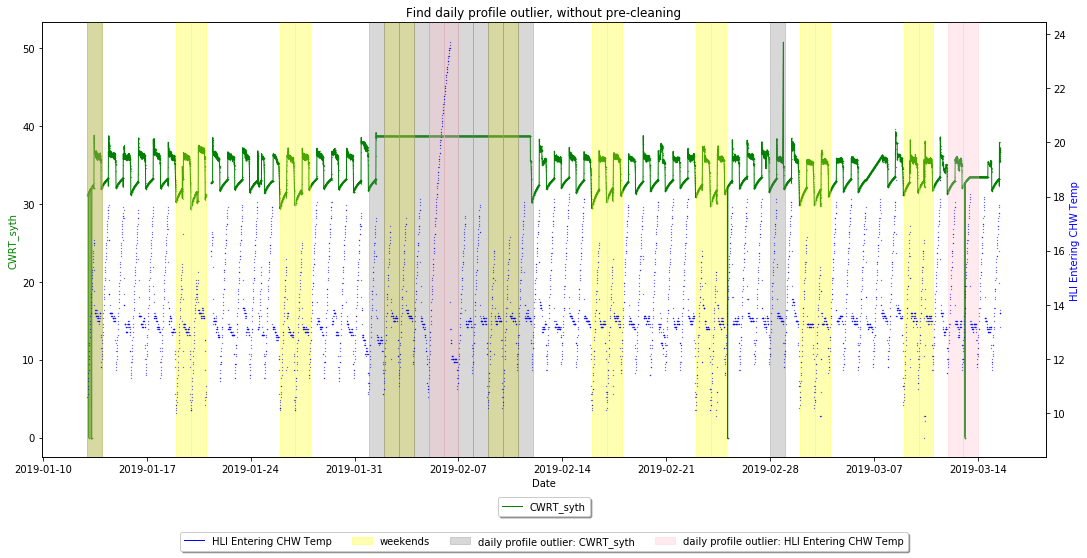

In [31]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2.index, data_2['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2.index, data_2['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1

# daily profile outlier
for col, clr in zip(maincols, ['grey', 'pink']):
    abnormaldays = np.unique(data_2[data_2[
        'LABEL_('+col+'_profile)_(outlier)']].index.date)
    tmp2 = data_2.index.to_frame()
    tmp2['date'] = tmp.index.date
    i = 0
    for dt in abnormaldays:
        alltm_dt = tmp[str(dt)].index
        if i == len(abnormaldays)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color=clr, 
                label='daily profile outlier: '+col)    
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color=clr)  
        i += 1
    
plt.title('Find daily profile outlier, without pre-cleaning')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()

#### Apply to cleaned data

In [32]:
# replace exteme value outliers with mean of the similar time (weekday, hourminute) 
data_2_modified = data_2.copy()

for col in maincols:
    data_2_modified = replaceoutlier(data_2_modified, col, how='median', timecols=['weekday', 'hourminute'])

display(data_2_modified.head())    

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  day  weekday  \
2019-01-13 00:00:00                                      False   13        7   
2019-01-13 00:05:00                                      False   13        7   
2019-01-13 00:10:00                                      False   13        7   
2019-01-13 00:15:00                                      False   13        7   
2019-01-13 00:20:00                                      False   13        7   

                     hourminute  LABEL_(CWRT_syth)_(extreme_value)  \
2019-01-13 00:00:00           0                              False   
2019-01-13 00:05:00           5                              False   
2019-01-13 00:10:00          10                              False   
2019-01-13 00:15:00          15                              False   
2019-01-13 00:20:00          20                              False   

                     LABEL_(HLI Entering CHW Temp)_(extreme_value)  \
2019-01-13 00:00:00                                          False   
2019-01-13 00:05:00                                          False   
2019-01-13 00:10:00                                          False   
2019-01-13 00:15:00                                          False   
2019-01-13 00:20:00                                          False   

                     LABEL_(CWRT_syth_profile)_(outlier)  \
2019-01-13 00:00:00                                 True   
2019-01-13 00:05:00                                 True   
2019-01-13 00:10:00                                 True   
2019-01-13 00:15:00                                 True   
2019-01-13 00:20:00                                 True   

                     LABEL_(HLI Entering CHW Temp_profile)_(outlier)  
2019-01-13 00:00:00                                            False  
2019-01-13 00:05:00                                            False  
2019-01-13 00:10:00                                            False  
2019-01-13 00:15:00                                            False  
2019-01-13 00:20:00                                            False

In [33]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_modified.index, data_2_modified['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_modified.index, data_2_modified['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2_modified.index.to_frame()
tmp['wkday'] = data_2_modified.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')

plt.title('Outlier Replaced by Median')
plt.show()

In [34]:
dfs = []
for col in maincols:
    tmp = data_2_modified.pivot(index='Date', columns='hourminute', values=col)
    tmp.columns = [col+'_'+str(c) for c in list(tmp)]
    dfs += [tmp]
dailypattern = pd.concat(dfs, axis=1)

display(dailypattern.head())

dailypattern_smry = dailypattern.describe().T
display(dailypattern_smry.head())

# remove the columns dailypattern where count is too few
dropcols = list(dailypattern_smry[dailypattern_smry['count']<len(dailypattern)*0.5].index)
print('drop columns:', len(dropcols))

print(dailypattern.shape)
dailypattern = dailypattern.drop(dropcols, axis=1)
print(dailypattern.shape)
display(dailypattern.head())

CWRT_syth_0  CWRT_syth_5  CWRT_syth_10  CWRT_syth_15  \
Date                                                               
2019-01-13    31.090000    31.106000     31.129999     31.146000   
2019-01-14    32.330002    32.346001     32.369999     32.385999   
2019-01-15    32.290001    32.290001     32.358000     32.459999   
2019-01-16    31.660000    31.690001     31.690001     31.706000   
2019-01-17    32.338001    32.369999     32.369999     32.369999   

            CWRT_syth_20  CWRT_syth_25  CWRT_syth_30  CWRT_syth_35  \
Date                                                                 
2019-01-13     31.170000         31.19     31.219999     31.219999   
2019-01-14     32.410000         32.41     32.410000     32.430000   
2019-01-15     32.475999         32.50     32.500000     32.516000   
2019-01-16     31.730000         31.73     31.746000     31.770000   
2019-01-17     32.377999         32.41     32.410000     32.410000   

            CWRT_syth_40  CWRT_syth_45  CWRT_syth_50  CWRT_syth_55  \
Date                                                                 
2019-01-13     31.236000     31.276000     31.299999     31.299999   
2019-01-14     32.459999     32.475999     32.500000     32.500000   
2019-01-15     32.540001     32.540001     32.560001     32.570000   
2019-01-16     31.790000     31.820000     31.820000     31.820000   
2019-01-17     32.420000     32.459999     32.459999     32.459999   

            CWRT_syth_60  CWRT_syth_65  CWRT_syth_70  CWRT_syth_75  \
Date                                                                 
2019-01-13     31.316000     31.340000     31.360000     31.389999   
2019-01-14     32.500000     32.516000     32.540001     32.540001   
2019-01-15     32.560001     32.590000     32.590000     32.590000   
2019-01-16     31.836000     31.860001     31.876000     31.900000   
2019-01-17     32.467999     32.500000     32.500000     32.500000   

            CWRT_syth_80  CWRT_syth_85  CWRT_syth_90  CWRT_syth_95  \
Date                                                                 
2019-01-13     31.389999     31.406000     31.430000     31.446000   
2019-01-14     32.560001     32.590000     32.590000     32.590000   
2019-01-15     32.606001     32.630001     32.630001     32.646000   
2019-01-16     31.900000     31.916000     31.940001     31.940001   
2019-01-17     32.508000     32.540001     32.540001     32.550001   

            CWRT_syth_100  CWRT_syth_105  CWRT_syth_110  CWRT_syth_115  \
Date                                                                     
2019-01-13      31.469999      31.469999      31.469999      31.490000   
2019-01-14      32.590000      32.606001      32.630001      32.630001   
2019-01-15      32.669998      32.669998      32.669998      32.685999   
2019-01-16      31.940001      31.960000      31.990000      31.990000   
2019-01-17      32.590000      32.590000      32.590000      32.590000   

            CWRT_syth_120  CWRT_syth_125  CWRT_syth_130  CWRT_syth_135  \
Date                                                                     
2019-01-13      30.850000      30.858001      30.878001      30.890000   
2019-01-14      32.646000      32.669998      32.669998      32.669998   
2019-01-15      32.709999      32.709999      32.709999      32.709999   
2019-01-16      32.005999      32.029999      32.029999      32.029999   
2019-01-17      32.598000      32.630001      32.630001      32.630001   

            CWRT_syth_140  CWRT_syth_145  CWRT_syth_150  CWRT_syth_155  \
Date                                                                     
2019-01-13      30.910000      30.940001      31.616000      31.639999   
2019-01-14      32.669998      32.685999      32.709999      32.709999   
2019-01-15      32.729999      32.759998      32.759998      32.759998   
2019-01-16      32.045999      32.070000      32.086000      32.110001   
2019-01-17      32.638000      32.669998      32.669998      32.669998   

            CW

count       mean       std        min      25%        50%  \
CWRT_syth_0    62.0  32.869742  2.749018  29.670000  31.6775  32.135000   
CWRT_syth_5    62.0  32.885774  2.740405  29.670000  31.7000  32.176000   
CWRT_syth_10   62.0  32.904694  2.732021  29.719999  31.7040  32.200001   
CWRT_syth_15   62.0  32.916984  2.725457  29.752000  31.7220  32.180000   
CWRT_syth_20   62.0  32.930274  2.718550  29.760000  31.7450  32.216001   

                    75%    max  
CWRT_syth_0   32.410000  38.75  
CWRT_syth_5   32.410000  38.75  
CWRT_syth_10  32.430000  38.75  
CWRT_syth_15  32.459999  38.75  
CWRT_syth_20  32.471999  38.75

drop columns: 192
(62, 576)
(62, 384)


CWRT_syth_0  CWRT_syth_5  CWRT_syth_10  CWRT_syth_15  \
Date                                                               
2019-01-13    31.090000    31.106000     31.129999     31.146000   
2019-01-14    32.330002    32.346001     32.369999     32.385999   
2019-01-15    32.290001    32.290001     32.358000     32.459999   
2019-01-16    31.660000    31.690001     31.690001     31.706000   
2019-01-17    32.338001    32.369999     32.369999     32.369999   

            CWRT_syth_20  CWRT_syth_25  CWRT_syth_30  CWRT_syth_35  \
Date                                                                 
2019-01-13     31.170000         31.19     31.219999     31.219999   
2019-01-14     32.410000         32.41     32.410000     32.430000   
2019-01-15     32.475999         32.50     32.500000     32.516000   
2019-01-16     31.730000         31.73     31.746000     31.770000   
2019-01-17     32.377999         32.41     32.410000     32.410000   

            CWRT_syth_40  CWRT_syth_45  CWRT_syth_50  CWRT_syth_55  \
Date                                                                 
2019-01-13     31.236000     31.276000     31.299999     31.299999   
2019-01-14     32.459999     32.475999     32.500000     32.500000   
2019-01-15     32.540001     32.540001     32.560001     32.570000   
2019-01-16     31.790000     31.820000     31.820000     31.820000   
2019-01-17     32.420000     32.459999     32.459999     32.459999   

            CWRT_syth_60  CWRT_syth_65  CWRT_syth_70  CWRT_syth_75  \
Date                                                                 
2019-01-13     31.316000     31.340000     31.360000     31.389999   
2019-01-14     32.500000     32.516000     32.540001     32.540001   
2019-01-15     32.560001     32.590000     32.590000     32.590000   
2019-01-16     31.836000     31.860001     31.876000     31.900000   
2019-01-17     32.467999     32.500000     32.500000     32.500000   

            CWRT_syth_80  CWRT_syth_85  CWRT_syth_90  CWRT_syth_95  \
Date                                                                 
2019-01-13     31.389999     31.406000     31.430000     31.446000   
2019-01-14     32.560001     32.590000     32.590000     32.590000   
2019-01-15     32.606001     32.630001     32.630001     32.646000   
2019-01-16     31.900000     31.916000     31.940001     31.940001   
2019-01-17     32.508000     32.540001     32.540001     32.550001   

            CWRT_syth_100  CWRT_syth_105  CWRT_syth_110  CWRT_syth_115  \
Date                                                                     
2019-01-13      31.469999      31.469999      31.469999      31.490000   
2019-01-14      32.590000      32.606001      32.630001      32.630001   
2019-01-15      32.669998      32.669998      32.669998      32.685999   
2019-01-16      31.940001      31.960000      31.990000      31.990000   
2019-01-17      32.590000      32.590000      32.590000      32.590000   

            CWRT_syth_120  CWRT_syth_125  CWRT_syth_130  CWRT_syth_135  \
Date                                                                     
2019-01-13      30.850000      30.858001      30.878001      30.890000   
2019-01-14      32.646000      32.669998      32.669998      32.669998   
2019-01-15      32.709999      32.709999      32.709999      32.709999   
2019-01-16      32.005999      32.029999      32.029999      32.029999   
2019-01-17      32.598000      32.630001      32.630001      32.630001   

            CWRT_syth_140  CWRT_syth_145  CWRT_syth_150  CWRT_syth_155  \
Date                                                                     
2019-01-13      30.910000      30.940001      31.616000      31.639999   
2019-01-14      32.669998      32.685999      32.709999      32.709999   
2019-01-15      32.729999      32.759998      32.759998      32.759998   
2019-01-16      32.045999      32.070000      32.086000      32.110001   
2019-01-17      32.638000      32.669998      32.669998      32.669998   

            CW

In [35]:
dailypattern.index = list(dailypattern.index.to_series().apply(
    lambda x: pd.datetime.strptime(x, '%Y-%m-%d')))
dailypattern['weekday'] = dailypattern.index.weekday+1

print(dailypattern.shape)
dailypattern = fillwithmean(dailypattern, grocol='weekday')
print(dailypattern.shape)

(62, 385)
(62, 385)


In [37]:
# ------------- 'CWRT_syth' -------------------
col = 'CWRT_syth'
time0 = time.time()
tmp = dailypattern[[c for c in list(dailypattern) if col in c]].copy()
for x in list(tmp):
    tmp[x] = stdnormalize(tmp[x])

def dmf(u, v):
    result, _ = fastdtw(u, v, dist=euclidean)
    return result

linked = linkage(tmp.values, method='single', metric=dmf)  #  metric=dmf  or  'euclidean'
dailypattern[col+'_cluster'] = fcluster(linked, 6, 'maxclust')
display(dailypattern[col+'_cluster'].value_counts(ascending=True))
print('total time used', time.time()-time0)


2     1
5     1
6     1
3     3
1     9
4    47
Name: CWRT_syth_cluster, dtype: int64

total time used 216.80424690246582


In [38]:
minor_clusters = list(dailypattern[col+'_cluster'].value_counts(ascending=True).index[:5])  # adjustable
abnormaldays = [str(x) for x in dailypattern[dailypattern[col+'_cluster'].isin(minor_clusters)].index.date]
labelcol = 'LABEL_('+col+'_profile)_(outlier)'
data_2_modified[labelcol] = False
data_2_modified.loc[data_2_modified['Date'].isin(abnormaldays), labelcol]=True


In [39]:
# ------------- 'HLI Entering CHW Temp' -------------------
col = 'HLI Entering CHW Temp'
time0 = time.time()
tmp = dailypattern[[c for c in list(dailypattern) if col in c]].copy()
for x in list(tmp):
    tmp[x] = stdnormalize(tmp[x])

def dmf(u, v):
    result, _ = fastdtw(u, v, dist=euclidean)
    return result

linked = linkage(tmp.values, method='single', metric=dmf)  #  metric=dmf  or  'euclidean'
dailypattern[col+'_cluster'] = fcluster(linked, 6, 'maxclust')
display(dailypattern[col+'_cluster'].value_counts(ascending=True))
print('total time used', time.time()-time0)


4     1
5     1
6     1
3     2
1    15
2    42
Name: HLI Entering CHW Temp_cluster, dtype: int64

total time used 72.30479693412781


In [40]:
minor_clusters = list(dailypattern[col+'_cluster'].value_counts(ascending=True).index[:4])  # adjustable
abnormaldays = [str(x) for x in dailypattern[dailypattern[col+'_cluster'].isin(minor_clusters)].index.date]
labelcol = 'LABEL_('+col+'_profile)_(outlier)'
data_2_modified[labelcol] = False
data_2_modified.loc[data_2_modified['Date'].isin(abnormaldays), labelcol]=True


In [41]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_modified.index, data_2_modified['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_modified.index, data_2_modified['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2_modified.index.to_frame()
tmp['wkday'] = data_2_modified.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1

# daily profile outlier
for col, clr in zip(maincols, ['grey', 'pink']):
    abnormaldays = np.unique(data_2_modified[data_2_modified[
        'LABEL_('+col+'_profile)_(outlier)']].index.date)
    tmp2 = data_2_modified.index.to_frame()
    tmp2['date'] = tmp.index.date
    i = 0
    for dt in abnormaldays:
        alltm_dt = tmp[str(dt)].index
        if i == len(abnormaldays)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color=clr, 
                label='daily profile outlier: '+col)    
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color=clr)  
        i += 1
    
plt.title('After Outliers are Replaced by Median, find daily profile outlier')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()

In [42]:
for col in maincols:
    data_2['LABEL_('+col+'_profile)_(outlier)'] = data_2_modified['LABEL_('+col+'_profile)_(outlier)']

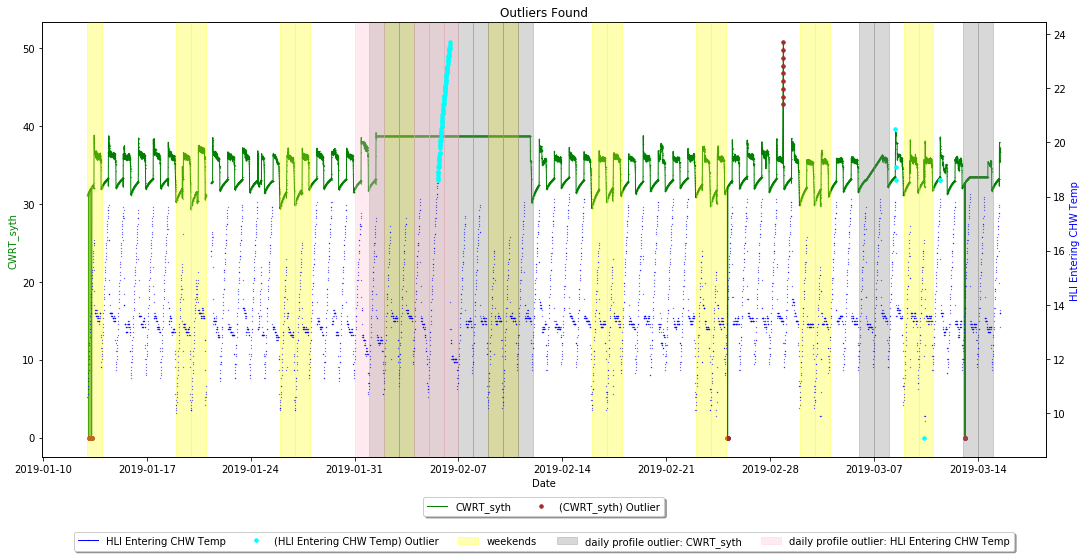

In [43]:
# --------- plot on original data with data_2_modified outlier label ----------------
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2.index, data_2['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2.index, data_2['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1

# daily profile outlier
for col, clr in zip(maincols, ['grey', 'pink']):
    abnormaldays = np.unique(data_2[data_2[
        'LABEL_('+col+'_profile)_(outlier)']].index.date)
    tmp2 = data_2.index.to_frame()
    tmp2['date'] = tmp.index.date
    i = 0
    for dt in abnormaldays:
        alltm_dt = tmp[str(dt)].index
        if i == len(abnormaldays)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color=clr, 
                label='daily profile outlier: '+col)    
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color=clr)  
        i += 1

# plot outliers
sub1 = data_2[data_2['LABEL_(CWRT_syth)_(extreme_value)']].copy()
ax1.plot_date(sub1.index, sub1['CWRT_syth'], 
              c='brown', markersize=7, marker='.', linewidth=1, linestyle='', label='(CWRT_syth) Outlier')
sub2 = data_2[data_2['LABEL_(HLI Entering CHW Temp)_(extreme_value)']].copy()
ax2.plot_date(sub2.index, sub2['HLI Entering CHW Temp'], 
              c='cyan', markersize=7,  marker='.', linewidth=1, linestyle='', label='(HLI Entering CHW Temp) Outlier')      
        
plt.title('Outliers Found')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


## <font color='purple'>Anomaly Type 4: Multivariate timestamp value anomaly</font>
1. <font color='grey'>make sure no timestamp is missed</font>
2. <font color='grey'>train underfitted model with data from the last step (data_2_modified), then predict on data_2 for multivariate timestamp value anomaly</font>

<font color='orange'>__*Assumption*__</font>: <font color='brown'>__high energy wastage anomaly__ and __inefficient equipment operation anomaly__ are minorities, and a predictor fitted to majority data can flag out the minorities</font>

In [44]:
data_2_modified_clean = data_2_modified.copy()
condi = data_2_modified_clean[[c for c in list(data_2_modified) if 'label' in c.lower()]].sum(axis=1)>0
rows_dataremoved = list(data_2_modified_clean[condi].index)
print('number of rows with data replaced by nan =', len(rows_dataremoved))

data_2_modified_clean.loc[condi, maincols] = np.nan
data_2_modified_clean = data_2_modified_clean[['CWRT_syth', 'HLI Entering CHW Temp', 'weekday', 'hourminute']].copy()

print(data_2_modified_clean.shape, data_2_modified.shape)
display(data_2_modified_clean.head())


number of rows with data replaced by nan = 4867
(17719, 4) (17719, 13)


CWRT_syth  HLI Entering CHW Temp  weekday  hourminute
2019-01-13 00:00:00  31.090000                    NaN        7           0
2019-01-13 00:05:00  31.106000                    NaN        7           5
2019-01-13 00:10:00  31.129999                   10.6        7          10
2019-01-13 00:15:00  31.146000                    NaN        7          15
2019-01-13 00:20:00  31.170000                    NaN        7          20

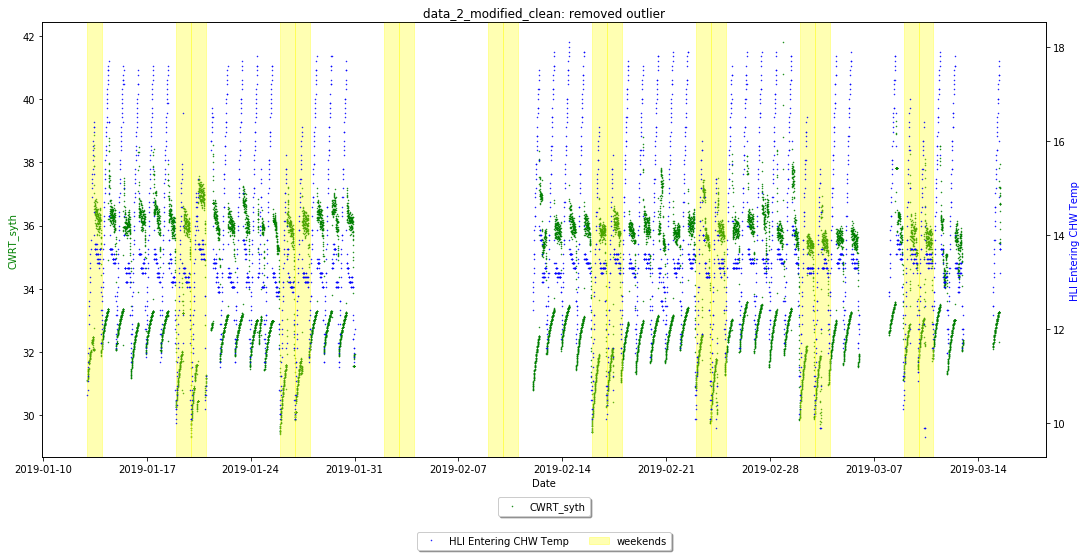

In [45]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_modified_clean.index, data_2_modified_clean['CWRT_syth'], 
              c='g', markersize=1, marker='.', linewidth=1, linestyle='', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_modified_clean.index, data_2_modified_clean['HLI Entering CHW Temp'], 
              c='b', markersize=1,  marker='.', linewidth=1, linestyle='', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2_modified_clean.index.to_frame()
tmp['wkday'] = data_2_modified_clean.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1
    
plt.title('data_2_modified_clean: removed outlier')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


#### save datasets for further discovery of anomaly type 4 :

In [46]:
data_2_modified_clean.to_csv('data_2_modified_clean.csv', index=True)
data_2.to_csv('data_2.csv', index=True)

In [47]:
data_2.to_csv('data_2.csv', index=True)